# 🧠 Motor Imagery Classifier — 2 Classes (Left vs Right)

**Goal:** Train and evaluate a binary MI classifier *(left-hand vs right-hand imagery)*.

---

## 🔁 Unit of Generalization

- **Unseen runs (within-subject):**  
  - Split **by run** *inside each subject*.  
  - Train on some runs, **test on held-out runs** of the **same** subject.

- **Unseen subjects (LOSO):**  
  - Split **by subject** using `GroupKFold` / `LeaveOneGroupOut`.  
  - Train on all but one subject, **test on the held-out subject**.

> Tip: Keep `X`, `y`, and `groups` aligned so that `groups` encodes **run IDs** for within-subject splits and **subject IDs** for LOSO.

---

## 📏 Evaluation Metrics

- **Accuracy** — standard proportion of correct predictions.
- **Cohen’s κ** — chance-corrected agreement (more robust under class imbalance).

> Report **mean ± SD** across folds for both metrics.

---

## ✅ Reporting Checklist

- [ ] Clearly state whether results are for **unseen runs** or **unseen subjects**.  
- [ ] Use the **same preprocessing** in train/test (fit transformers on *train only*).  
- [ ] Preserve **group boundaries** in CV splits.  
- [ ] Report **Accuracy** and **Cohen’s κ** per fold and aggregated.  
- [ ] Include **confusion matrices** (optional but helpful).

---


In [24]:
from pathlib import Path
import re, numpy as np, torch
import pandas as pd
import mne
from braindecode.models import EEGNet, ShallowFBCSPNet
from braindecode.util import set_random_seeds
from braindecode.datasets import create_from_mne_epochs
from braindecode.preprocessing import create_fixed_length_windows
from braindecode.training import CroppedLoss
from torch import nn
from torch.utils.data import DataLoader
import time
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, cohen_kappa_score
from braindecode.models import EEGNet
from braindecode.classifier import EEGClassifier
from skorch.dataset import ValidSplit
from skorch.callbacks import EarlyStopping, LRScheduler
import torch, torch.nn as nn

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys, importlib.util, os
parentPath = Path.cwd().parent
sys.path.insert(0, str(parentPath))  

DATA = Path(f"{parentPath}/data")
DER  = DATA / "derivatives"  
FIGS = Path(f"{parentPath}/figs"); FIGS.mkdir(parents=True, exist_ok=True)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("ERROR")

In [10]:
from src.utils_io import set_seeds, get_device

RUN = {
    "seed": 42,
    "device": get_device(),
    "timestamp": time.strftime("%Y-%m-%d_%H-%M-%S"),
}

set_seeds(RUN["seed"])
print(RUN)

{'seed': 42, 'device': device(type='mps'), 'timestamp': '2025-10-26_16-33-20'}


In [5]:

paths = sorted(DER.glob("*-epo.fif"))
paths = [p for p in paths if re.search(r"R(04|08|12)", p.name)]  # L/R imagery only

In [6]:
list_of_epochs = []
runs, subjects = [], []
for p in paths:

    ep = mne.read_epochs(p, preload=True, verbose=False)

    if len(ep)==0: continue
    run = int(re.search(r"R(\d{2})", p.name).group(1)); runs.extend([run]*len(ep))
    subj_name = re.search(r"(S\d{3})", p.name).group(1); subj_number = int(subj_name.lstrip("S")); subjects.extend([subj_number] * len(ep))
    list_of_epochs.append(ep)
runs = np.array(runs); subjects = np.array(subjects)

In [7]:
# Load & prepare dataset for Braindecode models
n_times = len(list_of_epochs[0].times)  # samples per epoch
windows_dataset = create_from_mne_epochs(
    list_of_epochs,                 # API expects a list of Epochs
    window_size_samples=n_times,    # full-epoch window
    window_stride_samples=n_times,  # stride=length -> 1 window/epoch
    drop_last_window=True,          # drop incomplete window
)

X = np.stack([ds[0] for ds in windows_dataset]).astype(np.float32)   # (N, C, T)
meta = pd.concat([ds.windows.metadata for ds in windows_dataset.datasets], ignore_index=True)
y = meta["target"].to_numpy().astype(int)  # (N,)
y = np.asarray(y, dtype=np.int64).reshape(-1)   # CE loss expects int64 class indices
subjects = np.asarray(subjects, dtype=np.int32).reshape(-1)
runs     = np.asarray(runs, dtype=np.int32).reshape(-1)


for name, arr in {"X": X, "y": y, "subjects": subjects, "runs": runs}.items():
    print(f"{name:8s} | shape: {arr.shape}, dtype: {arr.dtype}, "
          f"min/max: {np.min(arr):.3g}/{np.max(arr):.3g}" if arr.ndim==1 else
          f"{name:8s} | shape: {arr.shape}, dtype: {arr.dtype}")


X        | shape: (721, 64, 161), dtype: float32
y        | shape: (721,), dtype: int64, min/max: 0/1
subjects | shape: (721,), dtype: int32, min/max: 1/45
runs     | shape: (721,), dtype: int32, min/max: 4/12


In [43]:
from src.utils_io import EpochDataset, eval_with_preproc, make_eegnet, zscore_per_trial_pair, summarize, foldwise_channel_standardize_pair
EpochData = EpochDataset(X=X, y=y, sfreq=160, subjects=subjects, runs=runs)
print(EpochData.info)

EpochDataset: 721 trials, 64 channels, 161 timepoints, 2 classes, sfreq=160 Hz, 29 subjects, 3 runs


  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6733       0.6897        0.6855  0.0005  4.2817
      2        0.5932       0.7414        0.6720  0.0005  0.1378
      3        0.5419       0.7414        0.6492  0.0005  0.1267
      4        0.4978       0.7414        0.6224  0.0005  0.1262
      5        0.4695       0.7586        0.5991  0.0005  0.1264
      6        0.4425       0.7586        0.5777  0.0005  0.1247
      7        0.4312       0.7414        0.5609  0.0005  0.1275
      8        0.4298       0.7500        0.5485  0.0005  0.1258
      9        0.4146       0.7414        0.5356  0.0005  0.1251
     10        0.4023       0.7500        0.5239  0.0005  0.1280
     11        0.4011       0.7500        0.5144  0.0005  0.1278
     12        0.3900       0.7414        0.5042  0.0005  0.1267
     13        0.3754       0.7328        0.4989  0.0005  0.1274
     14        0.3679    

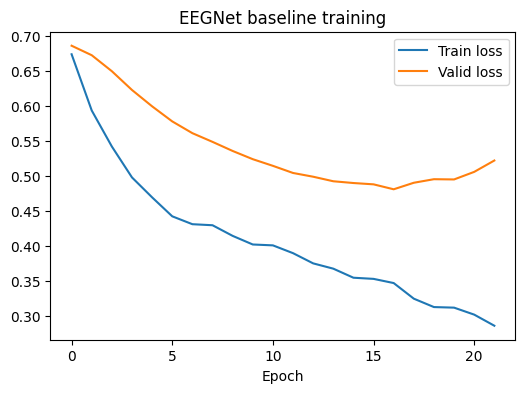

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6938       0.6293        0.6892  0.0005  0.8627
      2        0.6185       0.6034        0.6806  0.0005  0.1514
      3        0.5597       0.6379        0.6669  0.0005  0.1233
      4        0.5340       0.6552        0.6504  0.0005  0.1307
      5        0.5196       0.6638        0.6365  0.0005  0.1289
      6        0.4917       0.6638        0.6244  0.0005  0.1254
      7        0.4783       0.6897        0.6119  0.0005  0.1236
      8        0.4607       0.6983        0.5978  0.0005  0.1356
      9        0.4561       0.7155        0.5859  0.0005  0.1252
     10        0.4396       0.6983        0.5708  0.0005  0.1228
     11        0.4143       0.7155        0.5524  0.0005  0.1277
     12        0.4159       0.7155        0.5462  0.0005  0.1275
     13        0.4054       0.7069        0.5363  0.0005  0.1267
     14        0.4013    

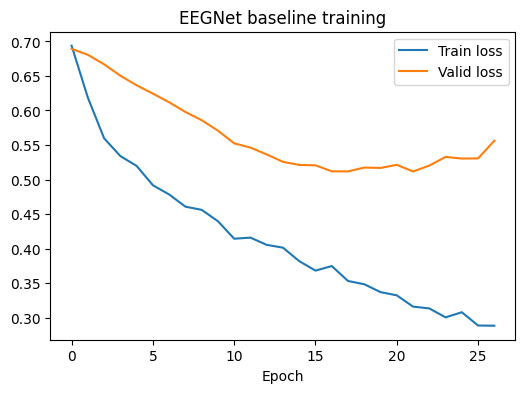

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6738       0.7155        0.6829  0.0005  0.1209
      2        0.6028       0.7586        0.6658  0.0005  0.1225
      3        0.5393       0.7500        0.6402  0.0005  0.1323
      4        0.5110       0.7672        0.6135  0.0005  0.1259
      5        0.4891       0.7586        0.5923  0.0005  0.1271
      6        0.4658       0.7586        0.5736  0.0005  0.1278
      7        0.4582       0.7586        0.5584  0.0005  0.1311
      8        0.4426       0.7845        0.5411  0.0005  0.1254
      9        0.4267       0.8103        0.5208  0.0005  0.1263
     10        0.4198       0.8103        0.5054  0.0005  0.1245
     11        0.4047       0.7931        0.4869  0.0005  0.1301
     12        0.3876       0.8103        0.4710  0.0005  0.1244
     13        0.3859       0.8103        0.4567  0.0005  0.1296
     14        0.3621    

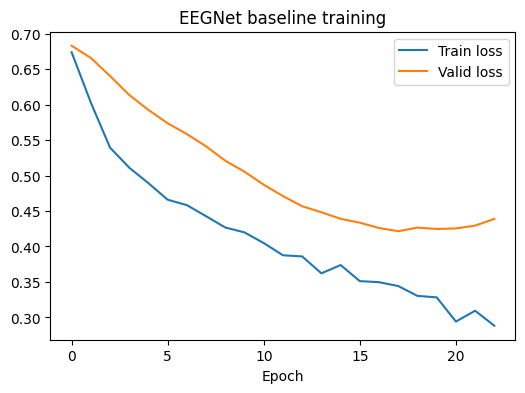

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6736       0.6466        0.6877  0.0005  0.1246
      2        0.6031       0.7328        0.6763  0.0005  0.1260
      3        0.5443       0.7155        0.6581  0.0005  0.1284
      4        0.5044       0.7414        0.6369  0.0005  0.1273
      5        0.4820       0.7414        0.6179  0.0005  0.1307
      6        0.4436       0.7328        0.6014  0.0005  0.1406
      7        0.4354       0.7328        0.5831  0.0005  0.1428
      8        0.4136       0.7328        0.5693  0.0005  0.1364
      9        0.4039       0.7586        0.5535  0.0005  0.1368
     10        0.3832       0.7414        0.5408  0.0005  0.1318
     11        0.3799       0.7241        0.5274  0.0005  0.1260
     12        0.3604       0.7414        0.5105  0.0005  0.1263
     13        0.3545       0.7414        0.5012  0.0005  0.1243
     14        0.3442    

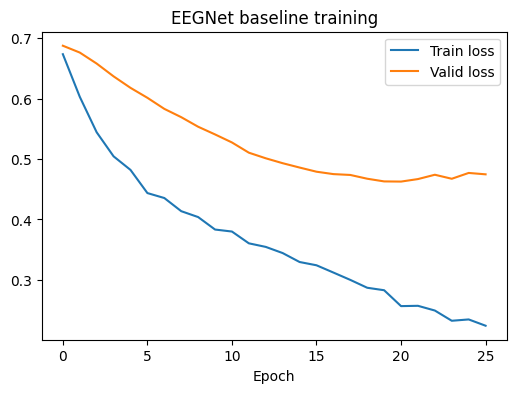

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6798       0.7241        0.6867  0.0005  0.1272
      2        0.6106       0.7931        0.6751  0.0005  0.1244
      3        0.5520       0.7845        0.6560  0.0005  0.1264
      4        0.5031       0.8017        0.6325  0.0005  0.1302
      5        0.4786       0.7845        0.6088  0.0005  0.1405
      6        0.4554       0.8017        0.5886  0.0005  0.1366
      7        0.4416       0.8017        0.5715  0.0005  0.1361
      8        0.4280       0.7845        0.5565  0.0005  0.1354
      9        0.4157       0.7931        0.5396  0.0005  0.1366
     10        0.3928       0.7931        0.5241  0.0005  0.1372
     11        0.3906       0.7845        0.5111  0.0005  0.1342
     12        0.3848       0.8017        0.4991  0.0005  0.1338
     13        0.3693       0.7759        0.4916  0.0005  0.1389
     14        0.3619    

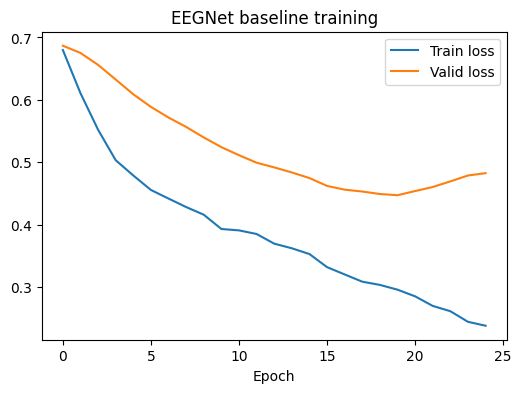

EEGNet + per-trial z-score     acc 0.759±0.055 | κ 0.517±0.111


In [41]:
baseline_acc_ztrial = eval_with_preproc(EpochData, 
                                        build_module=lambda: make_eegnet(EpochData = EpochData),
                                        preproc_pair_fn=zscore_per_trial_pair, 
                                        n_splits=5,
                                        plot_curves=True,
                                        filepath=FIGS)
summarize(baseline_acc_ztrial, "EEGNet + per-trial z-score")


In [42]:
baseline_acc_ztrial

[{'fold': 0, 'acc': 0.7172413793103448, 'kappa': 0.4297362110311751},
 {'fold': 1, 'acc': 0.8611111111111112, 'kappa': 0.7222222222222222},
 {'fold': 2, 'acc': 0.7291666666666666, 'kappa': 0.4589595375722543},
 {'fold': 3, 'acc': 0.7152777777777778, 'kappa': 0.4305555555555556},
 {'fold': 4, 'acc': 0.7708333333333334, 'kappa': 0.5421965317919075}]

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6585       0.7328        0.6797  0.0005  0.1562
      2        0.6014       0.7845        0.6658  0.0005  0.1261
      3        0.5573       0.7845        0.6468  0.0005  0.1237
      4        0.5197       0.7759        0.6243  0.0005  0.1251
      5        0.5054       0.7931        0.6037  0.0005  0.1263
      6        0.4690       0.7931        0.5831  0.0005  0.1250
      7        0.4400       0.7586        0.5634  0.0005  0.1268
      8        0.4240       0.7586        0.5433  0.0005  0.1245
      9        0.3988       0.7586        0.5243  0.0005  0.1240
     10        0.4071       0.7759        0.5113  0.0005  0.1248
     11        0.3918       0.7759        0.4963  0.0005  0.1257
     12        0.3723       0.7672        0.4791  0.0005  0.1254
     13        0.3537       0.7845        0.4621  0.0005  0.1249
     14        0.3586    

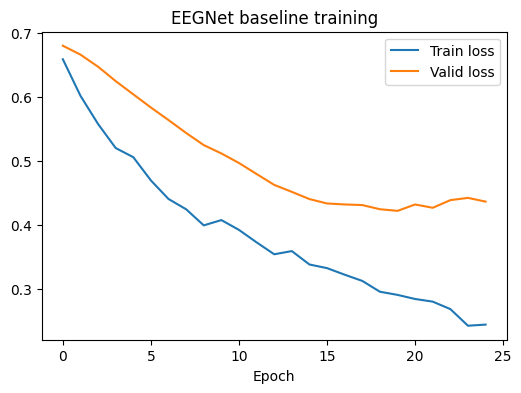

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6872       0.6379        0.6865  0.0005  0.1230
      2        0.6352       0.6983        0.6765  0.0005  0.1253
      3        0.5840       0.6983        0.6616  0.0005  0.1267
      4        0.5562       0.6983        0.6452  0.0005  0.1267
      5        0.5309       0.6983        0.6288  0.0005  0.1275
      6        0.5007       0.6983        0.6145  0.0005  0.1262
      7        0.4793       0.7069        0.6019  0.0005  0.1261
      8        0.4772       0.7155        0.5908  0.0005  0.1275
      9        0.4607       0.7328        0.5793  0.0005  0.1274
     10        0.4382       0.7155        0.5675  0.0005  0.1273
     11        0.4310       0.7155        0.5543  0.0005  0.1272
     12        0.4183       0.6897        0.5433  0.0005  0.1270
     13        0.4036       0.7241        0.5336  0.0005  0.1262
     14        0.3818    

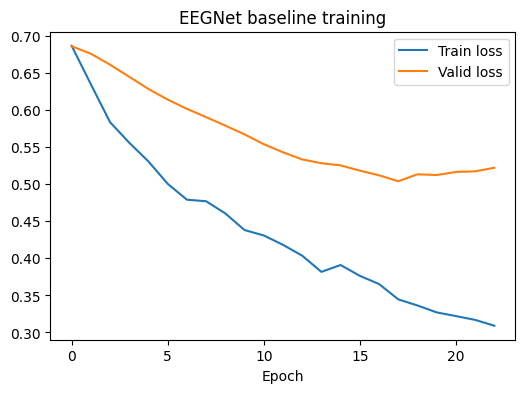

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6469       0.7672        0.6782  0.0005  0.1212
      2        0.5812       0.7586        0.6588  0.0005  0.1265
      3        0.5510       0.7500        0.6363  0.0005  0.1252
      4        0.5107       0.7586        0.6137  0.0005  0.1263
      5        0.4801       0.7586        0.5922  0.0005  0.1243
      6        0.4753       0.7500        0.5733  0.0005  0.1269
      7        0.4567       0.7672        0.5553  0.0005  0.1264
      8        0.4536       0.7672        0.5376  0.0005  0.1272
      9        0.4394       0.7672        0.5233  0.0005  0.1254
     10        0.4264       0.7759        0.5091  0.0005  0.1270
     11        0.4131       0.7845        0.4915  0.0005  0.1263
     12        0.3950       0.7759        0.4777  0.0005  0.1279
     13        0.3967       0.7672        0.4660  0.0005  0.1266
     14        0.3785    

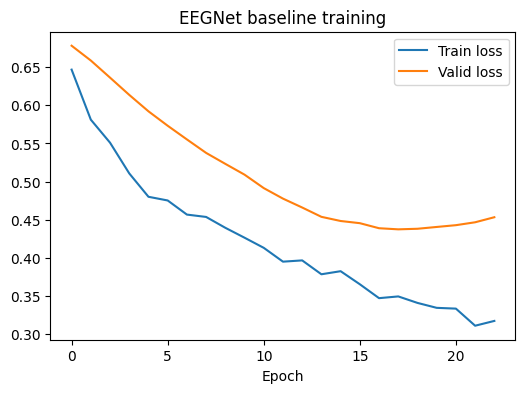

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7007       0.6207        0.6856  0.0005  0.1241
      2        0.6277       0.7155        0.6741  0.0005  0.1260
      3        0.5682       0.7155        0.6585  0.0005  0.1261
      4        0.5333       0.7069        0.6417  0.0005  0.1261
      5        0.4875       0.7241        0.6240  0.0005  0.1245
      6        0.4823       0.7069        0.6071  0.0005  0.1263
      7        0.4524       0.7241        0.5892  0.0005  0.1285
      8        0.4306       0.7241        0.5706  0.0005  0.1373
      9        0.4109       0.7414        0.5501  0.0005  0.1245
     10        0.4085       0.7414        0.5359  0.0005  0.1261
     11        0.4073       0.7414        0.5242  0.0005  0.1263
     12        0.3909       0.7328        0.5076  0.0005  0.1409
     13        0.3774       0.7328        0.4955  0.0005  0.1326
     14        0.3686    

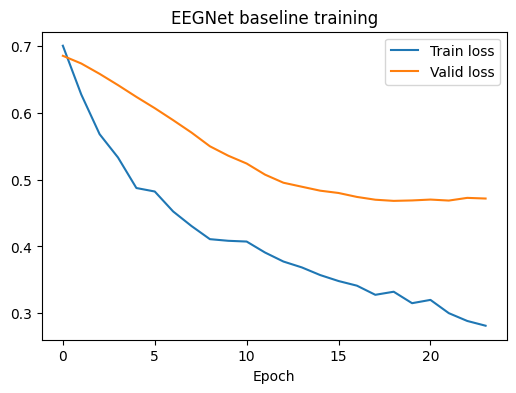

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7447       0.6897        0.6878  0.0005  0.1272
      2        0.6655       0.6638        0.6788  0.0005  0.1329
      3        0.6035       0.7155        0.6629  0.0005  0.1314
      4        0.5515       0.7414        0.6407  0.0005  0.1319
      5        0.5041       0.7500        0.6170  0.0005  0.1303
      6        0.4832       0.7672        0.5978  0.0005  0.1330
      7        0.4648       0.7586        0.5802  0.0005  0.1306
      8        0.4416       0.7414        0.5640  0.0005  0.1348
      9        0.4300       0.7586        0.5505  0.0005  0.1336
     10        0.4165       0.7500        0.5389  0.0005  0.1330
     11        0.3956       0.7586        0.5282  0.0005  0.1261
     12        0.3838       0.7586        0.5210  0.0005  0.1256
     13        0.3675       0.7672        0.5154  0.0005  0.1259
     14        0.3485    

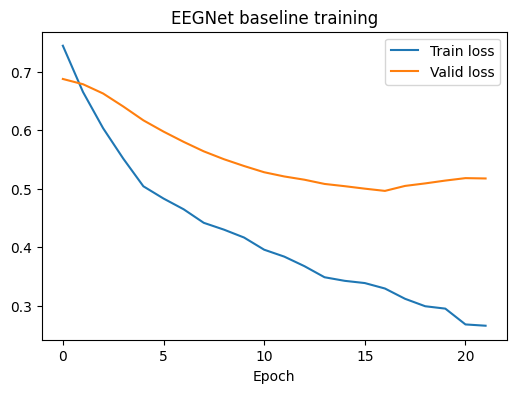

EEGNet + foldwise channel z-score acc 0.761±0.049 | κ 0.523±0.098


In [45]:
baseline_acc_foldstd = eval_with_preproc(EpochData, 
                                        build_module=lambda: make_eegnet(EpochData = EpochData),
                                        preproc_pair_fn=foldwise_channel_standardize_pair, 
                                        n_splits=5,
                                        plot_curves=True,
                                        filepath=FIGS)
summarize(baseline_acc_foldstd, "EEGNet + foldwise channel z-score")


In [ ]:
baseline_acc_ztrial

[{'fold': 0, 'acc': 0.7172413793103448, 'kappa': 0.4297362110311751},
 {'fold': 1, 'acc': 0.8611111111111112, 'kappa': 0.7222222222222222},
 {'fold': 2, 'acc': 0.7291666666666666, 'kappa': 0.4589595375722543},
 {'fold': 3, 'acc': 0.7152777777777778, 'kappa': 0.4305555555555556},
 {'fold': 4, 'acc': 0.7708333333333334, 'kappa': 0.5421965317919075}]

In [47]:
baseline_acc_foldstd

[{'fold': 0, 'acc': 0.7310344827586207, 'kappa': 0.4585926280516993},
 {'fold': 1, 'acc': 0.8472222222222222, 'kappa': 0.6944444444444444},
 {'fold': 2, 'acc': 0.7847222222222222, 'kappa': 0.5701078582434516},
 {'fold': 3, 'acc': 0.7291666666666666, 'kappa': 0.45833333333333337},
 {'fold': 4, 'acc': 0.7152777777777778, 'kappa': 0.43317972350230416}]

### fine hyperparameter tuning

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6961       0.6379        0.6860  0.0005  0.1433
      2        0.6268       0.6897        0.6723  0.0005  0.1259
      3        0.5904       0.7155        0.6521  0.0005  0.1272
      4        0.5348       0.7414        0.6265  0.0005  0.1271
      5        0.5140       0.7414        0.6013  0.0005  0.1280
      6        0.4734       0.7414        0.5787  0.0005  0.1327
      7        0.4796       0.7500        0.5605  0.0005  0.1304
      8        0.4613       0.7414        0.5438  0.0005  0.1317
      9        0.4517       0.7414        0.5278  0.0005  0.1319
     10        0.4496       0.7500        0.5134  0.0005  0.1297
     11        0.4377       0.7414        0.5022  0.0005  0.1317
     12        0.4132       0.7586        0.4910  0.0005  0.1322
     13        0.4137       0.7500        0.4786  0.0005  0.1300
     14        0.4062    

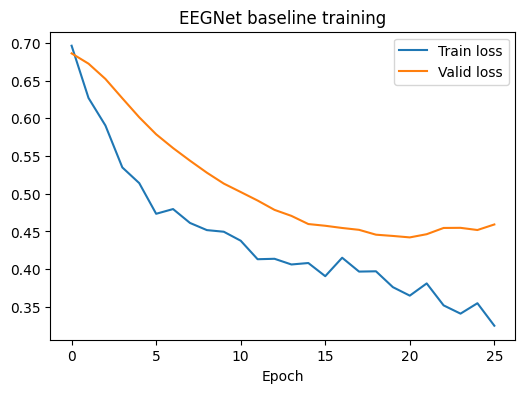

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7069       0.5603        0.6912  0.0005  0.1297
      2        0.6810       0.6034        0.6859  0.0005  0.1336
      3        0.6408       0.5948        0.6770  0.0005  0.1310
      4        0.5970       0.6293        0.6633  0.0005  0.1317
      5        0.5681       0.6552        0.6456  0.0005  0.1335
      6        0.5507       0.6810        0.6256  0.0005  0.1357
      7        0.5330       0.6810        0.6057  0.0005  0.1321
      8        0.5156       0.6810        0.5886  0.0005  0.1333
      9        0.4886       0.6897        0.5727  0.0005  0.1331
     10        0.4895       0.7069        0.5578  0.0005  0.1309
     11        0.4551       0.7241        0.5445  0.0005  0.1324
     12        0.4579       0.7155        0.5350  0.0005  0.1306
     13        0.4261       0.7155        0.5234  0.0005  0.1250
     14        0.4258    

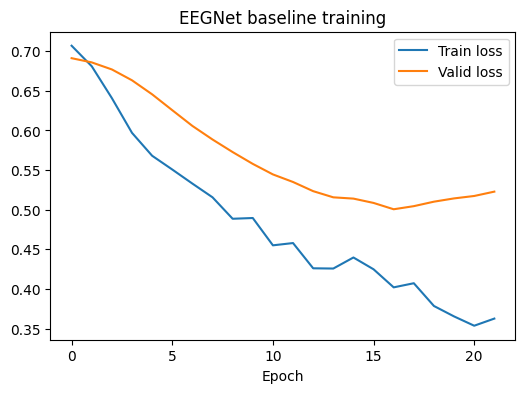

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7019       0.6293        0.6890  0.0005  0.1251
      2        0.6711       0.6638        0.6815  0.0005  0.1262
      3        0.6157       0.6983        0.6680  0.0005  0.1265
      4        0.5850       0.7155        0.6460  0.0005  0.1262
      5        0.5421       0.7241        0.6175  0.0005  0.1323
      6        0.5170       0.7328        0.5886  0.0005  0.1256
      7        0.5178       0.7414        0.5622  0.0005  0.1262
      8        0.4845       0.7500        0.5387  0.0005  0.1259
      9        0.4730       0.7500        0.5215  0.0005  0.1307
     10        0.4623       0.7672        0.5042  0.0005  0.1313
     11        0.4433       0.7931        0.4932  0.0005  0.1286
     12        0.4315       0.7931        0.4775  0.0005  0.1252
     13        0.4276       0.7845        0.4665  0.0005  0.1270
     14        0.4300    

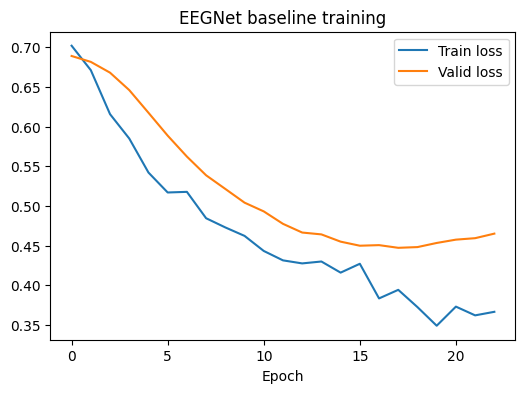

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6862       0.6466        0.6866  0.0005  0.1247
      2        0.5960       0.6983        0.6754  0.0005  0.1296
      3        0.5625       0.7069        0.6586  0.0005  0.1332
      4        0.5225       0.7241        0.6390  0.0005  0.1415
      5        0.4747       0.7241        0.6183  0.0005  0.1369
      6        0.4644       0.7241        0.5979  0.0005  0.1365
      7        0.4463       0.7155        0.5792  0.0005  0.1314
      8        0.4251       0.7241        0.5604  0.0005  0.1276
      9        0.4399       0.7155        0.5466  0.0005  0.1285
     10        0.4195       0.7155        0.5329  0.0005  0.1390
     11        0.3978       0.7414        0.5208  0.0005  0.1388
     12        0.3722       0.7069        0.5118  0.0005  0.1352
     13        0.3819       0.7069        0.5026  0.0005  0.1291
     14        0.3808    

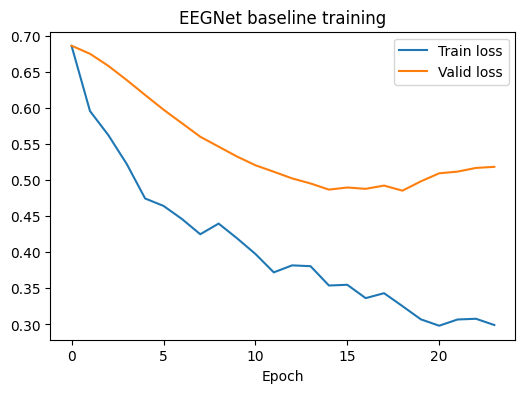

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6711       0.6638        0.6867  0.0005  0.1215
      2        0.6159       0.7328        0.6764  0.0005  0.1279
      3        0.5677       0.7414        0.6597  0.0005  0.1296
      4        0.5206       0.7500        0.6400  0.0005  0.1295
      5        0.4937       0.7500        0.6191  0.0005  0.1256
      6        0.4681       0.7759        0.6009  0.0005  0.1245
      7        0.4797       0.7845        0.5835  0.0005  0.1267
      8        0.4533       0.8017        0.5668  0.0005  0.1267
      9        0.4605       0.7759        0.5522  0.0005  0.1322
     10        0.4400       0.7759        0.5417  0.0005  0.1290
     11        0.4165       0.7500        0.5301  0.0005  0.1275
     12        0.4279       0.7500        0.5146  0.0005  0.1318
     13        0.4041       0.7414        0.5017  0.0005  0.1300
     14        0.4118    

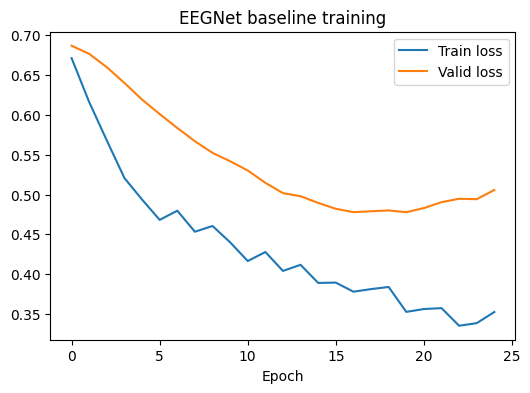

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6831       0.7500        0.6856  0.0005  0.2267
      2        0.6083       0.7500        0.6716  0.0005  0.2105
      3        0.5465       0.7414        0.6469  0.0005  0.2120
      4        0.4931       0.7414        0.6168  0.0005  0.2119
      5        0.4477       0.7586        0.5903  0.0005  0.2143
      6        0.4320       0.7672        0.5672  0.0005  0.2171
      7        0.4167       0.7672        0.5498  0.0005  0.2196
      8        0.4097       0.7759        0.5317  0.0005  0.2184
      9        0.4000       0.7845        0.5147  0.0005  0.2194
     10        0.3820       0.7672        0.5003  0.0005  0.2200
     11        0.3789       0.7759        0.4909  0.0005  0.2195
     12        0.3587       0.7845        0.4830  0.0005  0.2085
     13        0.3569       0.7845        0.4720  0.0005  0.2129
     14        0.3390    

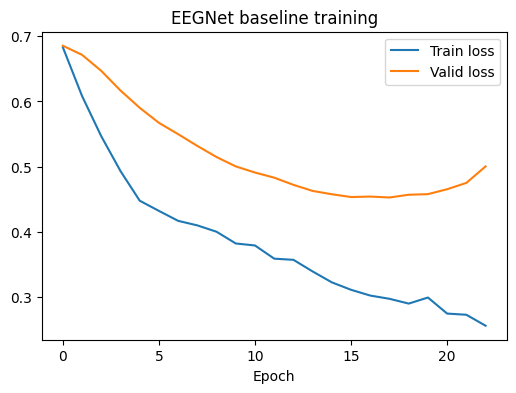

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6935       0.6466        0.6870  0.0005  0.2092
      2        0.6170       0.6724        0.6784  0.0005  0.2164
      3        0.5541       0.6983        0.6632  0.0005  0.2208
      4        0.5315       0.7069        0.6459  0.0005  0.2136
      5        0.4968       0.7155        0.6292  0.0005  0.2174
      6        0.4972       0.7241        0.6159  0.0005  0.2150
      7        0.4611       0.7414        0.6039  0.0005  0.2120
      8        0.4577       0.7414        0.5910  0.0005  0.2179
      9        0.4344       0.7414        0.5785  0.0005  0.2109
     10        0.4276       0.7328        0.5622  0.0005  0.2135
     11        0.4168       0.7500        0.5501  0.0005  0.2154
     12        0.3913       0.7500        0.5395  0.0005  0.2172
     13        0.3691       0.7155        0.5253  0.0005  0.2136
     14        0.3590    

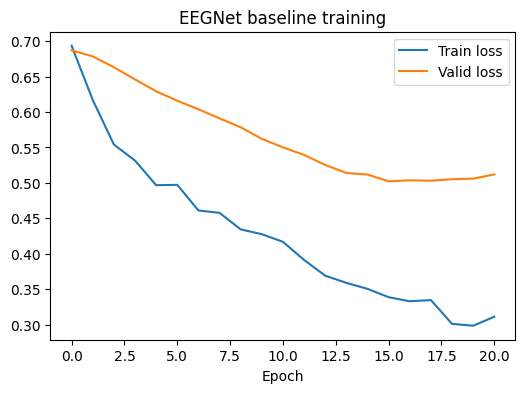

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7141       0.7328        0.6859  0.0005  0.2050
      2        0.5996       0.7672        0.6712  0.0005  0.1979
      3        0.5502       0.7500        0.6477  0.0005  0.1984
      4        0.5031       0.7500        0.6212  0.0005  0.1970
      5        0.4921       0.7500        0.5977  0.0005  0.1980
      6        0.4526       0.7586        0.5805  0.0005  0.2112
      7        0.4646       0.7845        0.5653  0.0005  0.2240
      8        0.4388       0.7931        0.5513  0.0005  0.2226
      9        0.4120       0.7931        0.5318  0.0005  0.2182
     10        0.4135       0.8017        0.5154  0.0005  0.2215
     11        0.3875       0.7845        0.4954  0.0005  0.2210
     12        0.3823       0.7931        0.4779  0.0005  0.2180
     13        0.3545       0.7845        0.4608  0.0005  0.2167
     14        0.3494    

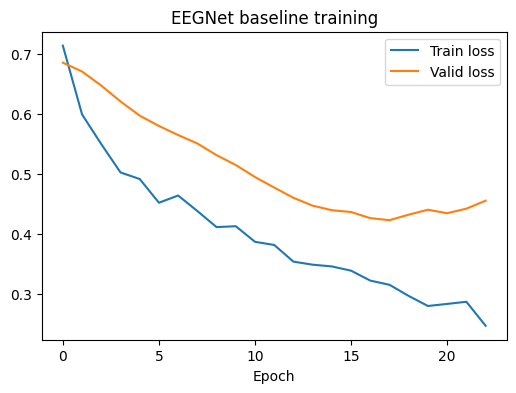

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6944       0.6034        0.6880  0.0005  0.1980
      2        0.5786       0.6638        0.6770  0.0005  0.1994
      3        0.5015       0.6897        0.6587  0.0005  0.2109
      4        0.4655       0.6983        0.6372  0.0005  0.2281
      5        0.4381       0.6897        0.6178  0.0005  0.2200
      6        0.4056       0.7155        0.6016  0.0005  0.2173
      7        0.3929       0.7241        0.5816  0.0005  0.2192
      8        0.3755       0.7241        0.5638  0.0005  0.2164
      9        0.3634       0.7328        0.5467  0.0005  0.2100
     10        0.3608       0.7328        0.5317  0.0005  0.2196
     11        0.3403       0.7414        0.5189  0.0005  0.2187
     12        0.3248       0.7328        0.5022  0.0005  0.2148
     13        0.3037       0.7586        0.4899  0.0005  0.2126
     14        0.3071    

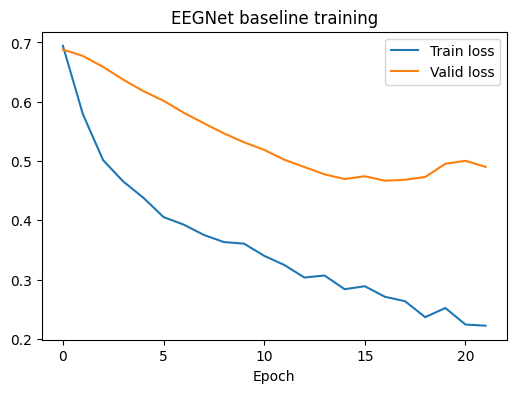

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6544       0.7500        0.6846  0.0005  0.1992
      2        0.5685       0.7845        0.6700  0.0005  0.1996
      3        0.5177       0.7672        0.6486  0.0005  0.1993
      4        0.4904       0.7845        0.6287  0.0005  0.2217
      5        0.4592       0.7586        0.6132  0.0005  0.2183
      6        0.4431       0.7414        0.5971  0.0005  0.2161
      7        0.4357       0.7328        0.5828  0.0005  0.2197
      8        0.4224       0.7328        0.5668  0.0005  0.2191
      9        0.3918       0.7328        0.5545  0.0005  0.2121
     10        0.3857       0.7586        0.5427  0.0005  0.2119
     11        0.3857       0.7500        0.5271  0.0005  0.2134
     12        0.3652       0.7500        0.5164  0.0005  0.2152
     13        0.3581       0.7328        0.5135  0.0005  0.2153
     14        0.3305    

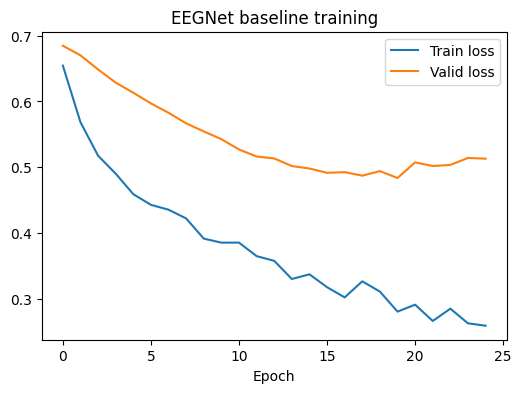

,F1,D,drop,acc_mean,acc_std,kappa_mean,kappa_std
0,16,2,0.5,0.764291,0.063300,0.528049,0.127450
1,8,2,0.5,0.744923,0.080135,0.488418,0.161945


Best (coarse): {'F1': 16.0, 'D': 2.0, 'drop': 0.5, 'acc_mean': 0.7642911877394637, 'acc_std': 0.06329986912388164, 'kappa_mean': 0.5280494991820897, 'kappa_std': 0.12744966850125702}


In [51]:
import numpy as np
import pandas as pd
from itertools import product

grid = {
    "F1":        [8, 16],
    "D":         [2],#[2, 4],
    "drop":     [0.5]#[0.25, 0.5],
}

results = []
for F1, D, drop in product(*grid.values()):
    rows = eval_with_preproc(
        EpochData,
        build_module=lambda: make_eegnet(EpochData = EpochData, F1=F1, D=D, drop=drop),
        preproc_pair_fn=zscore_per_trial_pair,
        n_splits=5,
        plot_curves=True,
        filepath=FIGS
    )
    accs   = [r["acc"] for r in rows]
    kappas = [r["kappa"] for r in rows]
    results.append({
        "F1": F1, "D": D, "drop": drop,
        "acc_mean": np.mean(accs), "acc_std": np.std(accs),
        "kappa_mean": np.mean(kappas), "kappa_std": np.std(kappas),
    })

tune_df = pd.DataFrame(results).sort_values("acc_mean", ascending=False).reset_index(drop=True)
display(tune_df.head(10))  # top configs
best = tune_df.iloc[0].to_dict()
print("Best (coarse):", best)


In [ ]:
'F1': 8.0, 'D': 2.0, 'drop': 0.5, 'epochs': 30.0, 'batch': 32.0, 'acc_mean': 0.7517633674630262, 'acc_std': 0.05274310656010483, 'kappa_mean': 0.5029765838789825, 'kappa_std': 0.10538937939036418}

  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6922       0.6979        0.6780  0.0005  2.0827
      2        0.6240       0.7702        0.6478  0.0005  2.1224
      3        0.5761       0.7617        0.6059  0.0005  401.1290
      4        0.5326       0.7532        0.5675  0.0005  2.4081
      5        0.5183       0.7489        0.5394  0.0005  2.1603
      6        0.5030       0.7532        0.5189  0.0005  2.1923
      7        0.4962       0.7489        0.4998  0.0005  2.0723
      8        0.4717       0.7532        0.4874  0.0005  2.3732
      9        0.4794       0.7574        0.4755  0.0005  2.0023
     10        0.4650       0.7489        0.4719  0.0005  1.9960
     11        0.4636       0.7574        0.4743  0.0005  2.0199
     12        0.4491       0.7574        0.4693  0.0005  2.1664
     13        0.4591       0.7574        0.4733  0.0005  2.0550
     14        0.4479  

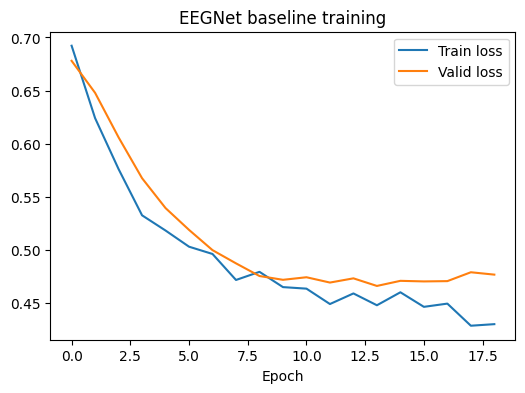

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold0_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6561       0.7362        0.6783  0.0005  2.0621
      2        0.5824       0.7532        0.6423  0.0005  2.0277
      3        0.5432       0.7532        0.6009  0.0005  2.0457
      4        0.5320       0.7702        0.5776  0.0005  2.0469
      5        0.5333       0.7830        0.5540  0.0005  2.1352
      6        0.5010       0.7915        0.5339  0.0005  2.0822
      7        0.5019       0.7915        0.5205  0.0005  1.9930
      8        0.4889       0.7957        0.5055  0.0005  2.0622
      9        0.4846       0.7915        0.4982  0.0005  2.0058
     10        0.4707       0.7872        0.4871  0.0005  1.9869
     11        0.4729       0.7702        0.4819  0.0005  1.9762
     12        0.4571       0.7745     

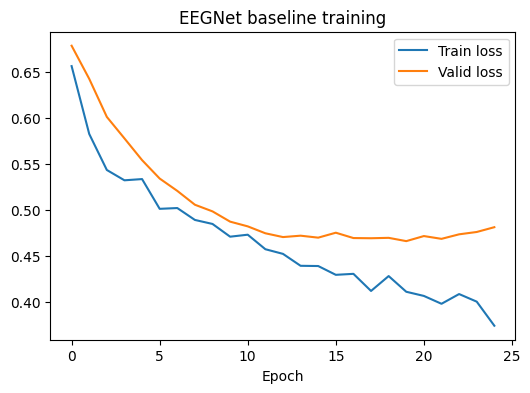

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold1_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.6866       0.6511        0.6885  0.0005  1.9961
      2        0.6295       0.6894        0.6689  0.0005  1.9934
      3        0.5619       0.7149        0.6283  0.0005  2.0320
      4        0.5083       0.7234        0.5914  0.0005  1.9836
      5        0.4966       0.7277        0.5638  0.0005  2.0752
      6        0.4897       0.7447        0.5520  0.0005  2.0260
      7        0.4938       0.7362        0.5396  0.0005  1.9962
      8        0.4871       0.7447        0.5321  0.0005  2.0369
      9        0.4722       0.7532        0.5277  0.0005  1.9772
     10        0.4593       0.7447        0.5226  0.0005  1.9945
     11        0.4459       0.7532        0.5201  0.0005  2.0321
     12        0.4498       0.7660     

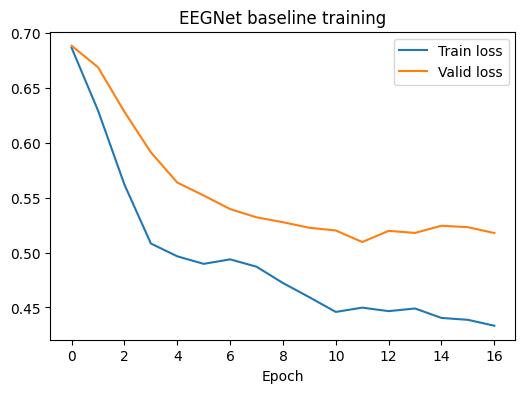

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold2_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7033       0.5745        0.6897  0.0005  2.0367
      2        0.6454       0.6383        0.6742  0.0005  2.0055
      3        0.5765       0.6638        0.6407  0.0005  2.0312
      4        0.5465       0.6723        0.6090  0.0005  2.0046
      5        0.5266       0.7021        0.5880  0.0005  2.0542
      6        0.5324       0.7021        0.5743  0.0005  2.0228
      7        0.5161       0.7021        0.5651  0.0005  2.0506
      8        0.5061       0.6979        0.5544  0.0005  2.0553
      9        0.5045       0.7149        0.5454  0.0005  2.0493
     10        0.5032       0.7064        0.5363  0.0005  2.0056
     11        0.4825       0.6979        0.5404  0.0005  2.0714
     12        0.4829       0.7021     

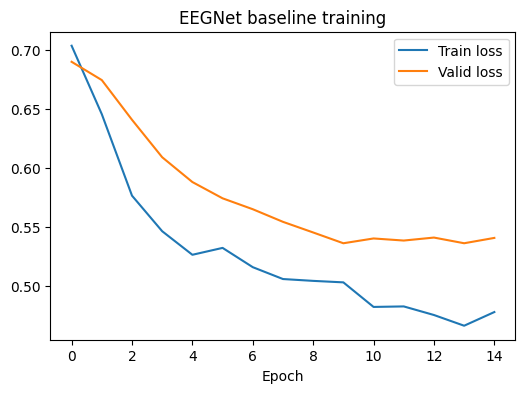

Training curves saved to /Users/suma/Documents/Motor-Imagery-EEG-Classifier-1/figs/EEGNet_fold3_training_curves.png
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.7035       0.6553        0.6887  0.0005  2.0196
      2        0.6531       0.7149        0.6715  0.0005  1.9889
      3        0.6148       0.7319        0.6361  0.0005  1.9683
      4        0.5742       0.7191        0.5993  0.0005  1.9851
      5        0.5573       0.7106        0.5816  0.0005  2.0758
      6        0.5432       0.7149        0.5678  0.0005  2.0398


In [ ]:
best_rows = eval_with_preproc(
    X, y, subjects,
    build_module=lambda: make_eegnet(F1=int(best["F1"]), D=int(best["D"]), drop=float(best["drop"])),
    preproc_pair_fn=zscore_per_trial_pair,
    n_splits=5,
    plot_curves=True,
    saveFigs=True,
    filepath=FIGS
)
summarize(best_rows, "EEGNet (best params) + per-trial z-score")


In [ ]:
from sklearn.metrics import accuracy_score, cohen_kappa_score
import numpy as np
import pandas as pd

def loso_final_eval(X, y, subjects, build_module, preproc_pair_fn, label="EEGNet LOSO"):
    """
    Leave-One-Subject-Out evaluation.
    X : (N, C, T)
    y : (N,)
    subjects : (N,) array of subject IDs
    build_module : function that returns a fresh EEG model
    preproc_pair_fn : function(X_train, X_test) -> (X_train_p, X_test_p)
    """
    unique_subs = np.unique(subjects)
    rows = []

    for sub in unique_subs:
        print(f"\n🧠 Testing on subject {sub}...")
        tr_idx = np.where(subjects != sub)[0]
        te_idx = np.where(subjects == sub)[0]

        Xtr, Xte = X[tr_idx], X[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]

        # preprocessing (safe: uses only train stats)
        Xtr_p, Xte_p = preproc_pair_fn(Xtr, Xte)

        # build and train
        clf = make_eeg_clf(build_module())
        clf.fit(Xtr_p, ytr)

        # predict on test subject
        yhat = clf.predict(Xte_p)
        acc = accuracy_score(yte, yhat)
        kappa = cohen_kappa_score(yte, yhat)

        rows.append(dict(sub=sub, acc=acc, kappa=kappa, n_test=len(yte)))
        print(f"   acc={acc:.3f}, κ={kappa:.3f}")

    df = pd.DataFrame(rows)
    print(f"\n{label}: acc {df.acc.mean():.3f}±{df.acc.std():.3f} | κ {df.kappa.mean():.3f}±{df.kappa.std():.3f}")
    return df


In [ ]:
# Final hold-out per subject (LOSO)
df_loso = loso_final_eval(
    X, y, subjects,
    build_module=lambda: make_eegnet(F1=8, D=2, drop=0.25),
    preproc_pair_fn=zscore_per_trial_pair,
    label="EEGNet + per-trial z-score (LOSO final test)"
)



🧠 Testing on subject 1...
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5627       0.7509        0.5254  0.0100  2.3966
      2        0.5045       0.7474        0.5130  0.0100  2.3957
      3        0.4898       0.7235        0.5444  0.0100  2.3931
      4        0.4698       0.7406        0.5290  0.0100  2.5476
      5        0.4419       0.7270        0.5649  0.0100  2.3534
      6        0.4425       0.7065        0.6060  0.0100  2.3783
Stopping since valid_loss has not improved in the last 5 epochs.
   acc=1.000, κ=1.000

🧠 Testing on subject 2...
  epoch    train_loss    valid_acc    valid_loss      lr     dur
-------  ------------  -----------  ------------  ------  ------
      1        0.5663       0.7569        0.4879  0.0100  2.4632
      2        0.5162       0.7500        0.4897  0.0100  2.3281
      3        0.5141       0.7639        0.4984  0.0100  2.3431
      4       

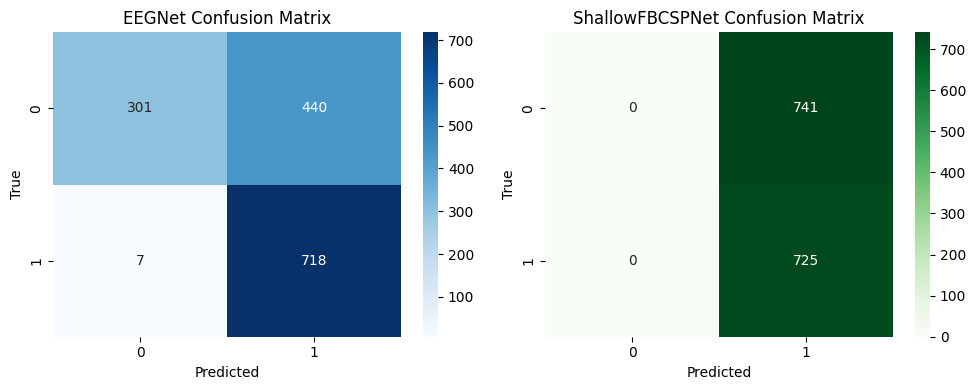

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm_eegnet = confusion_matrix(y, y_pred_eegnet)
cm_shallow = confusion_matrix(y, y_pred_shallow)
f, ax = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(cm_eegnet, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('EEGNet Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')
sns.heatmap(cm_shallow, annot=True, fmt='d', ax=ax[1], cmap='Greens')
ax[1].set_title('ShallowFBCSPNet Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
plt.tight_layout()
plt.show()#savefig(FIGS / "confusion_matrices.png", dpi=300)   

In [ ]:
# Visualize learned temporal kernel of EEGNet
import matplotlib.pyplot as plt
weights = clf.module_.conv_temporal.weight.detach().cpu().numpy()[0]
plt.plot(weights[0]); plt.title("Temporal kernel – EEGNet"); plt.tight_layout()
# plt.savefig("../figs/day7_eegnet_kernel.png",dpi=150)
plt.show()
